## Setup

In [61]:
%run setup.ipynb
# %matplotlib inline
# rcParams['figure.dpi'] = 120
# rcParams['figure.facecolor'] = 'w'
import hapclust
import cartopy; print('cartopy', cartopy.__version__)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import pandas as pd
# import numpy as np

cartopy 0.17.0


In [39]:
df_samples = phase2_ar1.df_samples
df_samples.rename(columns={"location":"region"}, inplace=True)
df_samples.columns

Index(['src_code', 'population', 'country', 'region', 'site', 'contributor',
       'contact', 'year', 'm_s', 'sex', 'n_sequences', 'mean_coverage',
       'ebi_sample_acc', 'latitude', 'longitude'],
      dtype='object')

In [40]:
df_samples

src_code population        country       region         site  \
ox_code                                                                         
AA0040-C  Twifo_Praso__E2      GHcol          Ghana  Twifo Praso  Twifo Praso   
AA0041-C  Twifo_Praso__H3      GHcol          Ghana  Twifo Praso  Twifo Praso   
AA0042-C      Takoradi_C7      GHcol          Ghana     Takoradi     Takoradi   
AA0043-C      Takoradi_H8      GHcol          Ghana     Takoradi     Takoradi   
AA0044-C     Takoradi_D10      GHcol          Ghana     Takoradi     Takoradi   
...                   ...        ...            ...          ...          ...   
AY0087-C       Tia_dPM_46      CIcol  Cote d'Ivoire     Tiassale     Tiassale   
AY0088-C       Tia_dPM_52      CIcol  Cote d'Ivoire     Tiassale     Tiassale   
AY0089-C        Tia_aPM_4      CIcol  Cote d'Ivoire     Tiassale     Tiassale   
AY0090-C       Tia_aPM_13      CIcol  Cote d'Ivoire     Tiassale     Tiassale   
AY0091-C       Tia_aPM_37      CIcol  Cote d'Ivoire     Tiassale     Tiassale   

            contributor        contact  year m_s sex  n_sequences  \
ox_code                                                             
AA0040-C  David Weetman  David Weetman  2012   M   F     95033368   
AA0041-C  David Weetman  David Weetman  2012   M   F     95843804   
AA0042-C  David Weetman  David Weetman  2012   M   F    107420666   
AA0043-C  David Weetman  David Weetman  2012   M   F     95993752   
AA0044-C  David Weetman  David Weetman  2012   M   F    103044262   
...                 ...            ...   ...  ..  ..          ...   
AY0087-C  David Weetman  David Weetman  2012   M   F    101458232   
AY0088-C  David Weetman  David Weetman  2012   M   F     95140584   
AY0089-C  David Weetman  David Weetman  2012   M   F     92383724   
AY0090-C  David Weetman  David Weetman  2012   M   F     96210618   
AY0091-C  David Weetman  David Weetman  2012   M   F     95973872   

          mean_coverage ebi_sample_acc  latitude  longitude  
ox_code                                                      
AA0040-C          30.99      ERS311878   5.60858   -1.54926  
AA0041-C          31.70      ERS311886   5.60858   -1.54926  
AA0042-C          35.65      ERS311894   4.91217   -1.77397  
AA0043-C          29.46      ERS311902   4.91217   -1.77397  
AA0044-C          33.67      ERS311910   4.91217   -1.77397  
...                 ...            ...       ...        ...  
AY0087-C          32.56      ERS311822   5.89839   -4.82293  
AY0088-C          30.75      ERS311830   5.89839   -4.82293  
AY0089-C          29.04      ERS311838   5.89839   -4.82293  
AY0090-C          30.94      ERS311846   5.89839   -4.82293  
AY0091-C          31.30      ERS311854   5.89839   -4.82293  

[1142 rows x 15 columns]

In [66]:
df_haplotypes = pd.read_csv('../phase2.AR1/haplotypes/haplotypes.autosomes.meta.txt', sep='\t')
df_haplotypes['region'] = df_haplotypes['region'].str.replace('_', " ")
df_haplotypes['region'] = df_haplotypes['region'].str.replace('Gado Badzere', "Gado-Badzere")
df_haplotypes['region'] = df_haplotypes['region'].str.replace('Zembe Borongo', "Zembe-Borongo")
df_haplotypes.head()

Unnamed: 0      label   ox_code population  \
0           0  AA0040-Ca  AA0040-C      GHcol   
1           1  AA0040-Cb  AA0040-C      GHcol   
2           2  AA0041-Ca  AA0041-C      GHcol   
3           3  AA0041-Cb  AA0041-C      GHcol   
4           4  AA0042-Ca  AA0042-C      GHcol   

                             label_aug country       region sex m_s  
0  AA0040-Ca [Ghana, Twifo_Praso, M F]   Ghana  Twifo Praso   F   M  
1  AA0040-Cb [Ghana, Twifo_Praso, M F]   Ghana  Twifo Praso   F   M  
2  AA0041-Ca [Ghana, Twifo_Praso, M F]   Ghana  Twifo Praso   F   M  
3  AA0041-Cb [Ghana, Twifo_Praso, M F]   Ghana  Twifo Praso   F   M  
4     AA0042-Ca [Ghana, Takoradi, M F]   Ghana     Takoradi   F   M

In [45]:
# use the network membership to define haplotype groups
vgsc_clusters = np.load('../data/median_joining_network_membership.npy').astype('U')
clust_dict = {(l if l else 'wt'): set(np.nonzero(vgsc_clusters == l)[0]) 
              for l in np.unique(vgsc_clusters)}


In [46]:
clust_dict.keys()

dict_keys(['wt', 'F1', 'F2', 'F3', 'F4', 'F5', 'FX', 'S1', 'S2', 'S3', 'S4', 'S5', 'SX'])

In [47]:
# merge the "other resistant" groups
clust_dict['other_resistant'] = clust_dict['FX'] | clust_dict['SX']
del clust_dict['FX']
del clust_dict['SX']

In [48]:
clust_dict.keys()

dict_keys(['wt', 'F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5', 'other_resistant'])

In [49]:
#using different clusterings/files

# with open('../data/clust_dict.pickle', 'rb') as handle:
#     clust_dict = peterpickedapickledpepper.load(handle)


# vgsc_clusters = np.load('../data/vgsc_cluster_membership.npy').astype('U')
# clust_dict = {(l if l else 'wt'): set(np.nonzero(vgsc_clusters == l)[0]) for l in np.unique(vgsc_clusters)}


# with open('../data/core_haps.pkl', mode='rb') as f:
#     clust_dict = pickle.load(f)
# core_haps_simple = dict()
# fx = set()
# sx = set()
# lx = set()
# wt = set()
# for k, v in clust_dict.items():
#     if k.startswith('FX'):
#         fx |= v
#     elif k.startswith('SX'):
#         sx |= v
#     elif k.startswith('LX'):
#         lx |= v
#     elif k.startswith('WT'):
#         wt |= v
#     else:
#         core_haps_simple[k] = v
# core_haps_simple['FX'] = fx
# core_haps_simple['SX'] = sx
# core_haps_simple['LX'] = lx
# core_haps_simple['WT'] = wt
# clust_dict = core_haps_simple

In [50]:
hap_labels = sorted(clust_dict)
# reorder for aesthetics
hap_labels = (
    [l for l in hap_labels if l.startswith('F')] +
    [l for l in hap_labels if l.startswith('S')] +
#     [l for l in hap_labels if l.startswith('L')] +
    ['other_resistant', 'wt']
)
hap_labels

['F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'S1',
 'S2',
 'S3',
 'S4',
 'S5',
 'other_resistant',
 'wt']

In [54]:
phase2_ar1.pop_labels

{'AOcol': 'Angola $coluzzii$',
 'BFcol': 'Burkina Faso $coluzzii$',
 'GHcol': 'Ghana $coluzzii$',
 'CIcol': "Côte d'Ivoire $coluzzii$",
 'GNcol': 'Guinea $coluzzii$',
 'GW': 'Guinea-Bissau',
 'GM': 'The Gambia',
 'GNgam': 'Guinea $gambiae$',
 'BFgam': 'Burkina Faso $gambiae$',
 'GHgam': 'Ghana $gambiae$',
 'CMgam': 'Cameroon $gambiae$',
 'UGgam': 'Uganda $gambiae$',
 'GAgam': 'Gabon $gambiae$',
 'GQgam': 'Bioko $gambiae$',
 'FRgam': 'Mayotte $gambiae$',
 'KE': 'Kenya',
 'colony': 'colony'}

In [69]:
def make_df_pops():
    global df_pops

    tbl_pops = (
        etl
        .wrap([
            ['pop', 'long_label', 'short_label', 'query'],
            ['AOcol', 'Angola $coluzzii$', 'AO$Ac$', 'population == "AOcol"'],
            ['GHcol', 'Ghana $coluzzii$', 'GH$Ac$', 'population == "GHcol"'],
            ['BFcol', 'Burkina Faso $coluzzii$', 'BF$Ac$', 'population == "BFcol"'],
            ['CIcol', "Côte d'Ivoire $coluzzii$", 'CI$Ac$', 'population == "CIcol"'],
            ['GNcol', "Guinea $coluzzii$", 'GN$Ac$', 'population == "GNcol"'],
            ['CMgam', 'Cameroon $gambiae$', 'CM$Ag$', 'population == "CMgam"'],
            ['CMgam_savanna', 'Cameroon (savanna) $gambiae$', 'CMgam', 'population == "CMgam" and (region == "Gado-Badzere" or region == "Zembe-Borongo")'],
            ['CMgam_transition', 'Cameroon (transition) $gambiae$', '', 'population == "CMgam" and region == "Daiguene"'],
            ['CMgam_forest', 'Cameroon (forest) $gambiae$', '', 'population == "CMgam" and region == "Mayos"'],
            ['GHgam', 'Ghana $gambiae$', 'GH$Ag$', 'population == "GHgam"'], 
            ['BFgam', 'Burkina Faso $gambiae$', 'BF$Ag$', 'population == "BFgam"'],
            ['GNgam', 'Guinea $gambiae$', 'GN$Ag$', 'population == "GNgam"'],
            ['GW', 'Guinea-Bissau', 'GW', 'population == "GW"'],
            ['GM', 'The Gambia', 'GM', 'population == "GM"'],
            ['GAgam', 'Gabon $gambiae$', 'GA$Ag$', 'population == "GAgam"'],
            ['UGgam', 'Uganda $gambiae$', 'UG$Ag$', 'population == "UGgam"'],
            ['FRgam', 'Mayotte $gambiae$', 'FR$Ag$', 'population == "FRgam"'],
            ['GQgam', 'Bioko $gambiae$', 'GQ$Ag$', 'population == "GQgam"'],
            ['KE', 'Kenya', 'KE', 'population == "KE"'],      
        ])
        .addfield('latitude', lambda row: df_samples.query(row.query).latitude.mean())
        .addfield('longitude', lambda row: df_samples.query(row.query).longitude.mean())
        .addfield('n_haps', lambda row: len(df_haplotypes.query(row.query)))
    )

    df_pops = tbl_pops.todataframe()
    df_pops = df_pops.set_index('pop')
    
    
make_df_pops()
df_pops

long_label short_label  \
pop                                                             
AOcol                           Angola $coluzzii$      AO$Ac$   
GHcol                            Ghana $coluzzii$      GH$Ac$   
BFcol                     Burkina Faso $coluzzii$      BF$Ac$   
CIcol                    Côte d'Ivoire $coluzzii$      CI$Ac$   
GNcol                           Guinea $coluzzii$      GN$Ac$   
CMgam                          Cameroon $gambiae$      CM$Ag$   
CMgam_savanna        Cameroon (savanna) $gambiae$               
CMgam_transition  Cameroon (transition) $gambiae$               
CMgam_forest          Cameroon (forest) $gambiae$               
GHgam                             Ghana $gambiae$      GH$Ag$   
BFgam                      Burkina Faso $gambiae$      BF$Ag$   
GNgam                            Guinea $gambiae$      GN$Ag$   
GW                                  Guinea-Bissau          GW   
GM                                     The Gambia          GM   
GAgam                             Gabon $gambiae$      GA$Ag$   
UGgam                            Uganda $gambiae$      UG$Ag$   
FRgam                           Mayotte $gambiae$      FR$Ag$   
GQgam                             Bioko $gambiae$      GQ$Ag$   
KE                                          Kenya          KE   

                                                              query  \
pop                                                                   
AOcol                                         population == "AOcol"   
GHcol                                         population == "GHcol"   
BFcol                                         population == "BFcol"   
CIcol                                         population == "CIcol"   
GNcol                                         population == "GNcol"   
CMgam                                         population == "CMgam"   
CMgam_savanna     population == "CMgam" and (region == "Gado-Bad...   
CMgam_transition     population == "CMgam" and region == "Daiguene"   
CMgam_forest            population == "CMgam" and region == "Mayos"   
GHgam                                         population == "GHgam"   
BFgam                                         population == "BFgam"   
GNgam                                         population == "GNgam"   
GW                                               population == "GW"   
GM                                               population == "GM"   
GAgam                                         population == "GAgam"   
UGgam                                         population == "UGgam"   
FRgam                                         population == "FRgam"   
GQgam                                         population == "GQgam"   
KE                                               population == "KE"   

                   latitude  longitude  n_haps  
pop                                             
AOcol             -8.821000  13.291000     156  
GHcol              5.377246  -1.317371     110  
BFcol             11.222600  -4.461400     150  
CIcol              5.898390  -4.822930     142  
GNcol              8.500000  -9.417000       8  
CMgam              4.936394  13.936182     594  
CMgam_savanna           NaN        NaN     192  
CMgam_transition   4.777000  13.844000     192  
CMgam_forest       4.341000  13.558000     210  
GHgam              5.668490  -0.219280      24  
BFgam             11.192065  -4.371304     184  
GNgam              8.912500  -9.692000      80  
GW                11.914894 -15.606377     182  
GM                13.550000 -15.900000     130  
GAgam              0.384000   9.455000     138  
UGgam              0.770000  34.026000     224  
FRgam            -12.865479  45.136410      48  
GQgam              3.700000   8.700000      18  
KE                -3.710667  39.820333      96

In [62]:
crs_lonlat = ccrs.PlateCarree()
ratios = np.asarray([0.5, 0.5])
sum(ratios)

1.0

## Calculate haplotype frequencies across populations

In [70]:
def compute_hap_freqs():
    global df_freqs
    
    n_pops = len(df_pops)
    n_haps = len(hap_labels)
    hap_frequencies = np.zeros([n_pops, n_haps], dtype=int)

    # then loop through clusters
    for i, pop in enumerate(df_pops.index):
        pop_query = df_pops.loc[pop].query
        pop_hap_ixs = set(df_haplotypes.query(pop_query).index.values)
        for j, label in enumerate(hap_labels):
            core_hap_ixs = clust_dict[label]
            isec = pop_hap_ixs.intersection(core_hap_ixs)
            hap_frequencies[i, j] = len(isec)


    counts = df_pops.n_haps
    counts

    # make df for plotting
    df_freqs = pd.DataFrame(data=hap_frequencies, index=df_pops.index, columns=hap_labels)
    df_freqs['other'] = counts - df_freqs.sum(axis=1).values
    df_freqs['total'] = counts
    
compute_hap_freqs()
df_freqs

F1  F2  F3  F4   F5   S1  S2   S3  S4  S5  other_resistant  \
pop                                                                             
AOcol             111   0   0   0    0    0   0    0   0   0               20   
GHcol              90   0   0   0    0    0   0    0   0   0                0   
BFcol             123   0   0   0    0    0   0    0   0   0                5   
CIcol             125   0   0   0    0    0   0    0   0   0                5   
GNcol               6   0   0   0    0    0   0    0   0   0                1   
CMgam              28  13  55  23  159    0   8    0  37  42               40   
CMgam_savanna       2   3  29  12   40    0   1    0  11  14               16   
CMgam_transition   15   5  18   5   57    0   4    0  10  12               13   
CMgam_forest       11   5   8   6   62    0   3    0  16  16               11   
GHgam              24   0   0   0    0    0   0    0   0   0                0   
BFgam             183   0   0   0    0    0   0    0   0   0                1   
GNgam              80   0   0   0    0    0   0    0   0   0                0   
GW                  0   0   0   0    0    0   0    0   0   0                0   
GM                  0   0   0   0    0    0   0    0   0   0                0   
GAgam               0   0   0  17   28    0  89    0   0   0                4   
UGgam               0   0   0   0    0  117   0  106   0   0                1   
FRgam               0   0   0   0    0    0   0    0   0   0                0   
GQgam               0   0   0   0    0    0   0    0   0   0                0   
KE                  0   0   0   0    0    0   0   71   0   0                2   

                   wt  other  total  
pop                                  
AOcol              25      0    156  
GHcol              20      0    110  
BFcol              22      0    150  
CIcol              12      0    142  
GNcol               1      0      8  
CMgam             189      0    594  
CMgam_savanna      64      0    192  
CMgam_transition   53      0    192  
CMgam_forest       72      0    210  
GHgam               0      0     24  
BFgam               0      0    184  
GNgam               0      0     80  
GW                182      0    182  
GM                130      0    130  
GAgam               0      0    138  
UGgam               0      0    224  
FRgam              48      0     48  
GQgam              18      0     18  
KE                 23      0     96

In [72]:
# test CMS breakdown is significant
def test_cms_breakdown():
    arr = np.asarray(df_freqs
                     .loc[['CMgam_savanna', 'CMgam_transition', 'CMgam_forest']]
                     .iloc[:, :len(hap_labels) + 1])
    # remove zeros
    arr = arr.compress(arr.sum(axis=0) > 0, axis=1)
    return scipy.stats.chi2_contingency(arr)

test_cms_breakdown()

(37.903481675425965,
 0.0039888456078261,
 18,
 array([[ 9.05050505,  4.2020202 , 17.77777778,  7.43434343, 51.39393939,
          2.58585859, 11.95959596, 13.57575758, 12.92929293, 61.09090909],
        [ 9.05050505,  4.2020202 , 17.77777778,  7.43434343, 51.39393939,
          2.58585859, 11.95959596, 13.57575758, 12.92929293, 61.09090909],
        [ 9.8989899 ,  4.5959596 , 19.44444444,  8.13131313, 56.21212121,
          2.82828283, 13.08080808, 14.84848485, 14.14141414, 66.81818182]]))

## build matplotlib pies - use colours from original dendrogram

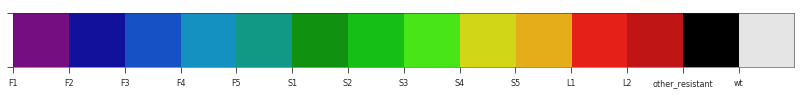

In [14]:
palette = sns.color_palette('nipy_spectral', n_colors=len(hap_labels) - 2, desat=0.8)
# add a colour for other_resistant
palette.append((0, 0, 0))
# add a colour for wt 
palette.append((0.9, 0.9, 0.9))
# check
sns.palplot(palette)
plt.gca().set_xticklabels(hap_labels);

In [15]:
df_pops

long_label short_label  \
pop                                                           
AOM                           Angola $coluzzii$      AO$Ac$   
BFM                     Burkina Faso $coluzzii$      BF$Ac$   
BFS                      Burkina Faso $gambiae$      BF$Ag$   
GNS                            Guinea $gambiae$      GN$Ag$   
CMS                          Cameroon $gambiae$      CM$Ag$   
CMS_savanna        Cameroon (savanna) $gambiae$      CM$Ag$   
CMS_transition  Cameroon (transition) $gambiae$               
CMS_forest          Cameroon (forest) $gambiae$               
GAS                             Gabon $gambiae$      GA$Ag$   
UGS                            Uganda $gambiae$      UG$Ag$   
KES                                       Kenya          KE   
GWA                               Guinea-Bissau          GW   

                                                            query   latitude  \
pop                                                                            
AOM                                           population == "AOM"  -8.821000   
BFM                                           population == "BFM"  11.221609   
BFS                                           population == "BFS"  11.193630   
GNS                                           population == "GNS"   8.887097   
CMS                                           population == "CMS"   4.937851   
CMS_savanna     population == "CMS" and (region == "Gado-Badze...   5.747000   
CMS_transition       population == "CMS" and region == "Daiguene"   4.777000   
CMS_forest              population == "CMS" and region == "Mayos"   4.341000   
GAS                                           population == "GAS"   0.384000   
UGS                                           population == "UGS"   0.770000   
KES                                           population == "KES"  -3.702068   
GWA                                           population == "GWA"  11.891000   

                longitude  n_haps  
pop                                
AOM             13.291000     120  
BFM             -4.457739     138  
BFS             -4.376556     162  
GNS             -9.675065      62  
CMS             13.936844     550  
CMS_savanna     14.442000     182  
CMS_transition  13.844000     166  
CMS_forest      13.558000     202  
GAS              9.455000     112  
UGS             34.026000     206  
KES             39.824614      88  
GWA            -15.582000      92

In [16]:
def make_df_lonlat():
    global df_lonlat
    df_lonlat = df_pops[['latitude', 'longitude']].copy()
    df_lonlat['offset_latitude'] = np.zeros(len(df_lonlat))
    df_lonlat['offset_longitude'] = np.zeros(len(df_lonlat))
    df_lonlat.loc['BFS'].offset_latitude = 2
    df_lonlat.loc['BFS'].offset_longitude = 2
    df_lonlat.loc['BFM'].offset_latitude = 2
    df_lonlat.loc['BFM'].offset_longitude = -2
    df_lonlat.loc['CMS_savanna'].offset_latitude = 3.5
    df_lonlat.loc['CMS_savanna'].offset_longitude = 0.5
    df_lonlat.loc['CMS_transition'].offset_latitude = 0.5
    df_lonlat.loc['CMS_transition'].offset_longitude = 3
    df_lonlat.loc['CMS_forest'].offset_latitude = -3
    df_lonlat.loc['CMS_forest'].offset_longitude = 1
    df_lonlat.loc['GAS'].offset_latitude = .5
    df_lonlat.loc['GAS'].offset_longitude = -3

make_df_lonlat()
df_lonlat

latitude  longitude  offset_latitude  offset_longitude
pop                                                                    
AOM             -8.821000  13.291000              0.0               0.0
BFM             11.221609  -4.457739              2.0              -2.0
BFS             11.193630  -4.376556              2.0               2.0
GNS              8.887097  -9.675065              0.0               0.0
CMS              4.937851  13.936844              0.0               0.0
CMS_savanna      5.747000  14.442000              3.5               0.5
CMS_transition   4.777000  13.844000              0.5               3.0
CMS_forest       4.341000  13.558000             -3.0               1.0
GAS              0.384000   9.455000              0.5              -3.0
UGS              0.770000  34.026000              0.0               0.0
KES             -3.702068  39.824614              0.0               0.0
GWA             11.891000 -15.582000              0.0               0.0

In [17]:
# for legend
hap_colors = {l: c for l, c in zip(hap_labels, palette)}
hap_colors

{'F1': (0.45607725490196099, 0.056599607843137223, 0.50939647058823534),
 'F2': (0.06784647058823523, 0.06784647058823523, 0.61061823529411763),
 'F3': (0.086670000000000025, 0.32093509803921522, 0.78003),
 'F4': (0.084317058823529356, 0.57059470588235295, 0.75885352941176476),
 'F5': (0.066670000000000007, 0.60002999999999995, 0.52679078431372561),
 'S1': (0.063397843137254828, 0.57058058823529412, 0.063397843137254828),
 'S2': (0.083269607843137194, 0.74942647058823542, 0.083269607843137194),
 'S3': (0.2840439215686274, 0.90000000000000002, 0.099999999999999978),
 'S4': (0.82193117647058844, 0.84703235294117651, 0.094114705882352934),
 'S5': (0.90000000000000002, 0.68039215686274546, 0.099999999999999978),
 'L1': (0.90000000000000002, 0.12823529411764703, 0.099999999999999978),
 'L2': (0.74942647058823542, 0.083269607843137194, 0.083269607843137194),
 'other_resistant': (0, 0, 0),
 'wt': (0.9, 0.9, 0.9)}

In [18]:
df_lonlat.loc[['BFS', 'BFM']]

latitude  longitude  offset_latitude  offset_longitude
pop                                                         
BFS  11.193630  -4.376556              2.0               2.0
BFM  11.221609  -4.457739              2.0              -2.0

In [19]:
pops_cms_whole = [p for p in df_pops.index if p not in {'CMS_savanna', 'CMS_transition', 'CMS_forest'}]
pops_cms_whole

['AOM', 'BFM', 'BFS', 'GNS', 'CMS', 'GAS', 'UGS', 'KES', 'GWA']

In [20]:
pops_cms_breakdown = [p for p in df_pops.index if p != 'CMS']
pops_cms_breakdown

['AOM',
 'BFM',
 'BFS',
 'GNS',
 'CMS_savanna',
 'CMS_transition',
 'CMS_forest',
 'GAS',
 'UGS',
 'KES',
 'GWA']

In [21]:
human_hap_labels = {k: k for k in hap_labels}
human_hap_labels['other_resistant'] = 'other $kdr$'
human_hap_labels['wt'] = '$wt$'

In [22]:
def plot_map(pops, fn=None, dpi=150):

    #our frame
    extent_lonlat = (-20, 45, -13, 20)

    #plot
    subplot_kw = dict(projection=crs_lonlat)
    fig, ax = plt.subplots(figsize=(7, 7), dpi=120, subplot_kw=subplot_kw)
    ax.coastlines(resolution='50m', linewidth=1, zorder=1)
    ax.stock_img()
    ax.add_feature(cfeature.BORDERS, lw=1, zorder=4)
    ax.add_feature(cfeature.LAKES)
    #ax.margins(0)

    #add pies
    for pop, row in df_lonlat.loc[pops].iterrows():
        freqs = df_freqs.loc[pop]
        ratios = np.asarray([freqs[k]/freqs['total'] for k in hap_labels])
        ratios = np.append(ratios, 1 - np.sum(ratios))
        # wedgeprops is used here just to pass the zorder command
        center = (row.longitude + row.offset_longitude, row.latitude + row.offset_latitude)
        radius = np.sqrt(df_freqs.loc[pop].total * .02)
        ax.pie(ratios, wedgeprops=dict(zorder=7), colors=palette, 
               center=center, radius=radius, shadow=True)
        ax.add_patch(plt.Circle(xy=center, radius=radius, facecolor='none', edgecolor='k', zorder=8, lw=1))
        if row.offset_latitude > 0 or row.offset_longitude > 0:
            ax.plot([row.longitude, row.longitude + row.offset_longitude],
                    [row.latitude, row.latitude + row.offset_latitude], 'k-', lw=2)
        lbl = df_pops.loc[pop].short_label
        ax.text(center[0], center[1] + radius, lbl, ha='center', va='bottom', fontsize=8, fontweight='bold', 
                bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=.8, ), zorder=6)

    ax.set_extent(extent_lonlat, crs=crs_lonlat)

    handles = [mpl.patches.Patch(facecolor=hap_colors[k], edgecolor='k', label=human_hap_labels[k]) for k in hap_labels]
    leg = ax.legend(handles=handles, bbox_to_anchor=(1, 1), loc='upper left', title='Haplotype\ngroup', )
    leg._legend_box.align = "left"
    
    #save
    if fn:
        fig.savefig(fn, jpeg_quality=100, dpi=dpi, bbox_inches='tight')
    

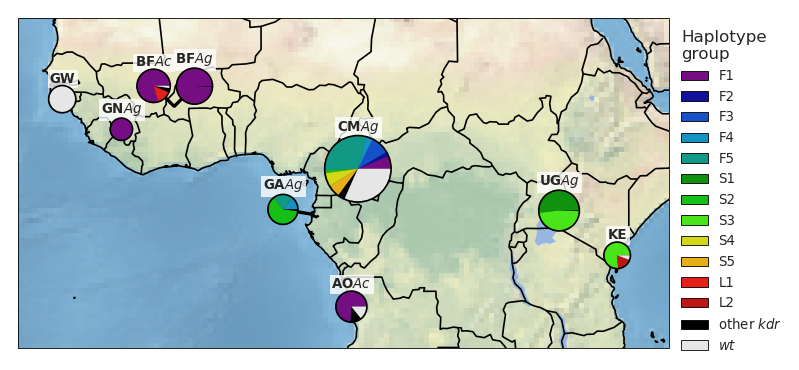

In [23]:
plot_map(pops=pops_cms_whole, fn='../artwork/outbreak_map_base.pdf')

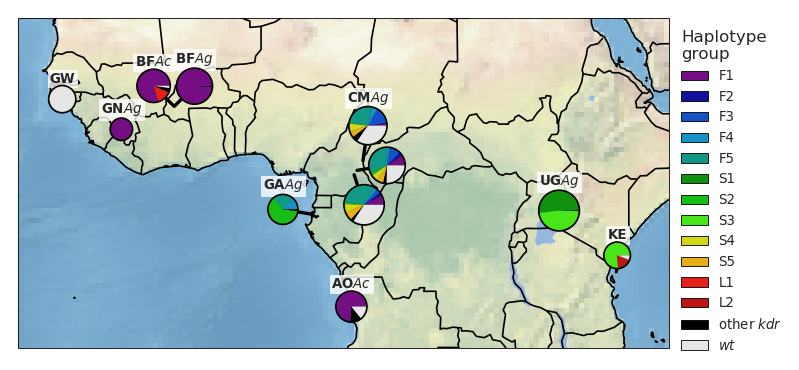

In [24]:
plot_map(pops=pops_cms_breakdown, fn='../artwork/outbreak_map_base_cms_breakdown.pdf')